# Part 3 - Run the ML model on data collected from and API. Send the output to PostgreSQL

In this part, we will:
- Collect weather data for the coming 7 days using an API from meteo.com
- Preprocess the data
- Use the data as input for the ML model
- Postprocess the output data
- Add information from other sources to the data
- Upload the data to a postgreSQL database

In [1]:
# 1) import relevant libraries

import pandas as pd
import numpy as np
import urllib.request
import urllib.parse
import psycopg2
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import date
from joblib import dump, load
from pandas.io.json import json_normalize
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# if you get an error saying psycopg2 is not installed. Uncomment the line below, run this cell and re-run the cell above.
#pip install psycopg2-binary

The output of this script will be uploaded to PostgreSQL. Then, the data will be pulled from PostgreSQL by Apache Superset to build the Data-informed Government Spendings Dashboard. Fill in the credentials of you PostgreSQL instance below. You can find your credentials in the BDTI portal. If you have not already made a PostgreSQL instance. Have a look at Step 2 from the User Guide related to '1: Smart Data Ingestion'.

In [3]:
# 2) define the DB engine parameters

drivername = 'postgresql' 
# EDIT THIS LINE
host = '<postgresSQLHost>'
port = '5432'
username = 'postgres'
# EDIT THIS LINE 
password = '<postgreSQLPassword>'
database = 'postgres'

DATABASE = {
    'drivername': drivername,
    'host': host,
    'port': port,
    'username': username,
    'password': password,
    'database': database
}

In [4]:
# 3) fetch data for next week's weather from the Open-meteo API and normalize it

url = "https://api.open-meteo.com/v1/forecast?latitude=53.33&longitude=-6.25&hourly=rain,cloudcover,visibility,windspeed_80m,temperature_80m&daily=sunrise,sunset&windspeed_unit=kn&timezone=auto"
response = urllib.request.urlopen(url)
record_list = json.loads(response.read())
df = pd.json_normalize(record_list)

In [5]:
# 4) substitute "." with "_" for JSON nested levels

df_columns = df.columns.tolist()
df_columns = [c.replace('.','_') for c in df_columns]
df.columns = df_columns
df_columns

['latitude',
 'longitude',
 'generationtime_ms',
 'utc_offset_seconds',
 'timezone',
 'timezone_abbreviation',
 'elevation',
 'hourly_units_time',
 'hourly_units_rain',
 'hourly_units_cloudcover',
 'hourly_units_visibility',
 'hourly_units_windspeed_80m',
 'hourly_units_temperature_80m',
 'hourly_time',
 'hourly_rain',
 'hourly_cloudcover',
 'hourly_visibility',
 'hourly_windspeed_80m',
 'hourly_temperature_80m',
 'daily_units_time',
 'daily_units_sunrise',
 'daily_units_sunset',
 'daily_time',
 'daily_sunrise',
 'daily_sunset']

In [6]:
# 5) save all parameters

time = df["hourly_time"]
rain = df["hourly_rain"]
cloudcover = df["hourly_cloudcover"]
visibility = df["hourly_visibility"]
windspeed = df["hourly_windspeed_80m"]
temperature = df["hourly_temperature_80m"]
sunrise = df["daily_sunrise"]
sunset = df["daily_sunset"]

In [7]:
# 6) concatenate series data

time_conc = np.stack(time)
rain_conc = np.stack(rain)
cloudcover_conc = np.stack(cloudcover)
visibility_conc = np.stack(visibility)
windspeed_conc = np.stack(windspeed)
temperature_conc = np.stack(temperature)
sunrise_conc = np.stack(sunrise)
sunset_conc = np.stack(sunset)

In [8]:
# 7) transpose

time_transposed = pd.DataFrame(time_conc).transpose()
rain_transposed = pd.DataFrame(rain_conc).transpose()
cloudcover_transposed = pd.DataFrame(cloudcover_conc).transpose()
visibility_transposed = pd.DataFrame(visibility_conc).transpose()
windspeed_transposed = pd.DataFrame(windspeed_conc).transpose()
temperature_transposed = pd.DataFrame(temperature_conc).transpose()
sunrise_transposed = pd.DataFrame(sunrise_conc).transpose()
sunset_transposed = pd.DataFrame(sunset_conc).transpose()

In [9]:
# 8) rename columns

time_transposed.columns = ['hourly_time']
rain_transposed.columns = ['rain']
cloudcover_transposed.columns = ['clamt']
visibility_transposed.columns = ['vis']
windspeed_transposed.columns = ['wdsp']
temperature_transposed.columns = ['temp']
sunrise_transposed.columns = ['sunrise']
sunset_transposed.columns = ['sunset']

In [10]:
# 9) merge the data into two dataframes, one for hourly data and one for daily data

pd.set_option('display.max_rows', 20)
hourly_data = pd.concat([time_transposed.reset_index(drop = True),rain_transposed.reset_index(drop = True),temperature_transposed.reset_index(drop = True),windspeed_transposed.reset_index(drop=True),visibility_transposed.reset_index(drop=True),cloudcover_transposed.reset_index(drop = True)],axis = 1)
hourly_data['hourly_time'] = pd.to_datetime(hourly_data['hourly_time'])
hourly_data

hourly_time  rain  temp  wdsp      vis  clamt
0   2023-03-02 00:00:00   0.0   6.0  16.3  24140.0     73
1   2023-03-02 01:00:00   0.0   5.9  15.4  24140.0     96
2   2023-03-02 02:00:00   0.0   5.9  14.7  24140.0     95
3   2023-03-02 03:00:00   0.0   5.9  16.3  24140.0     98
4   2023-03-02 04:00:00   0.0   6.0  14.3  24140.0     95
..                  ...   ...   ...   ...      ...    ...
163 2023-03-08 19:00:00   0.0   3.6   1.3  24140.0    100
164 2023-03-08 20:00:00   0.0   3.5   2.2  24140.0    100
165 2023-03-08 21:00:00   0.0   3.4   3.1  24140.0    100
166 2023-03-08 22:00:00   0.0   3.3   3.7  24140.0    100
167 2023-03-08 23:00:00   0.0   3.1   3.9  24140.0    100

[168 rows x 6 columns]

Because the data will be used to calculate the cost of public lighting, it is valuable to enrich the data with a column 'light', that is 1 when it is dark and 0 when it is light. This column will be added using the ['sunrise'] and ['sunset'] data from the meteo.com API.

In [11]:
# 10) merge the pre-processed daily objects into a dataframe

daily_data = pd.concat([sunrise_transposed.reset_index(drop = True),sunset_transposed.reset_index(drop = True)],axis = 1)
daily_data['sunrise'] = pd.to_datetime(daily_data['sunrise'])
daily_data['sunset'] = pd.to_datetime(daily_data['sunset'])
daily_data

sunrise              sunset
0 2023-03-02 07:08:00 2023-03-02 18:05:00
1 2023-03-03 07:06:00 2023-03-03 18:07:00
2 2023-03-04 07:03:00 2023-03-04 18:09:00
3 2023-03-05 07:01:00 2023-03-05 18:11:00
4 2023-03-06 06:59:00 2023-03-06 18:13:00
5 2023-03-07 06:56:00 2023-03-07 18:15:00
6 2023-03-08 06:54:00 2023-03-08 18:17:00

In [12]:
# 11) add a light {0,1} column to the hourly data

days = daily_data.shape[0]
hours = hourly_data.shape[0]
lightarray = [] # 1 for night, 0 for day

# loop over the hourly data
for i in np.arange(0,hours,1):
    
    j = np.floor(i/24) #(loop the daily data over days)
    sunrise = daily_data.loc[j]['sunrise']
    sunset = daily_data.loc[j]['sunset']
    
    if sunrise < hourly_data.loc[i]['hourly_time'] and  hourly_data.loc[i]['hourly_time'] < sunset:
        lightarray.append(0)
    else:
        lightarray.append(1)
        
hourly_data['light'] = lightarray

In [13]:
# 12) a few more preprocessing steps are needed to match the outlay of the training data

# Spread the datetime over columns
hourly_data['year'] = hourly_data['hourly_time'].dt.year
hourly_data['month'] = hourly_data['hourly_time'].dt.month
hourly_data['day'] = hourly_data['hourly_time'].dt.day_name()
hourly_data['hour'] = hourly_data['hourly_time'].dt.hour

# Change categorical calues to booleans
data = hourly_data.drop(['hourly_time'],axis=1)
data = pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rain           168 non-null    float64
 1   temp           168 non-null    float64
 2   wdsp           168 non-null    float64
 3   vis            168 non-null    float64
 4   clamt          168 non-null    int64  
 5   light          168 non-null    int64  
 6   year           168 non-null    int64  
 7   month          168 non-null    int64  
 8   hour           168 non-null    int64  
 9   day_Friday     168 non-null    uint8  
 10  day_Monday     168 non-null    uint8  
 11  day_Saturday   168 non-null    uint8  
 12  day_Sunday     168 non-null    uint8  
 13  day_Thursday   168 non-null    uint8  
 14  day_Tuesday    168 non-null    uint8  
 15  day_Wednesday  168 non-null    uint8  
dtypes: float64(4), int64(5), uint8(7)
memory usage: 13.1 KB


In [14]:
# 13) let's load the ML model we trained earlier and normalise the data like the training data

rfModel = load('MLmodel.joblib') 
sc = StandardScaler()
data = sc.fit_transform(data)

# N.B. You might get an error about the versioning of sklearn. You can ignore this error.

In [15]:
# 14) predict the traffic volumes and add the predictions as a column

y_pred_r = rfModel.predict(data)
hourly_data['predicted_traffic_volume'] = y_pred_r

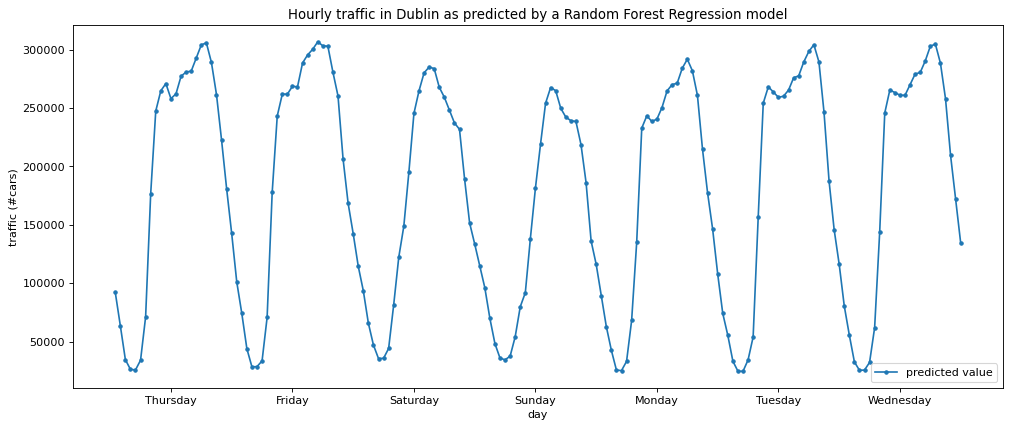

In [16]:
# 15) let's look at the predicted traffic volumes for the coming week:

hours = len(hourly_data.index)
x = hourly_data.index
y1 = hourly_data['predicted_traffic_volume']

# setup x-ticks
xloc = np.arange(11,hours-12,24)
xlab = hourly_data.loc[xloc]['day']

figure(figsize=(15, 6), dpi=80)

plt.plot(x,y1,marker='.',label = 'predicted value')
plt.xticks(xloc,labels=xlab)
plt.xlabel("day")
plt.ylabel("traffic (#cars)")
plt.title("Hourly traffic in Dublin as predicted by a Random Forest Regression model")
plt.legend()

In [17]:
# 16) postprocessing: Add columns for date filtering

hourly_data['day_format'] = hourly_data['day'] + ", " + hourly_data['hourly_time'].dt.month_name() + " " + hourly_data['hourly_time'].dt.day.astype(str)
hourly_data['day_order'] = np.round((hourly_data.index.to_numpy()+13)/24)
hourly_data['hourly_time'] = hourly_data['hourly_time'].dt.strftime('%d-%m-%Y')
hourly_data.head()

hourly_time  rain  temp  wdsp      vis  clamt  light  year  month       day  \
0  02-03-2023   0.0   6.0  16.3  24140.0     73      1  2023      3  Thursday   
1  02-03-2023   0.0   5.9  15.4  24140.0     96      1  2023      3  Thursday   
2  02-03-2023   0.0   5.9  14.7  24140.0     95      1  2023      3  Thursday   
3  02-03-2023   0.0   5.9  16.3  24140.0     98      1  2023      3  Thursday   
4  02-03-2023   0.0   6.0  14.3  24140.0     95      1  2023      3  Thursday   

   hour  predicted_traffic_volume         day_format  day_order  
0     0                  92258.15  Thursday, March 2        1.0  
1     1                  63725.58  Thursday, March 2        1.0  
2     2                  34556.70  Thursday, March 2        1.0  
3     3                  26202.90  Thursday, March 2        1.0  
4     4                  25714.49  Thursday, March 2        1.0

So we have our predicted traffic for the coming week! The prediction is partly based on the weather forecast that we downloaded using the API. Next thing we need to do is work out what the traffic will be on street level. We do this using a table 'traffic_fractions', which contains the fraction of total traffic going to every street (on average). So when the total traffic volume is 100.000 cars/hour. A street with a fraction of 0.002 will have an estimated traffic volume of 200 cars/hour.

In [18]:
# 17) now let's calculate what this prediction means for all streets individually:

fractiondata = pd.read_csv('dags/data/traffic_fractions.csv')
fractiondata.info()
fractiondata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PostalStre   774 non-null    object 
 1   NLights      774 non-null    int64  
 2   Watts        774 non-null    int64  
 3   FracTraffic  774 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 24.3+ KB


PostalStre  NLights  Watts  FracTraffic
0                 N11 South Bound      290  54737     0.006506
1                 N11 North Bound      281  55337     0.005053
2  GLENCAIRN ESTATE (THE GALLOPS)      149   7238     0.004662
3                RATHSALLAGH PARK      135   4877     0.004521
4                BROADFORD ESTATE      133   6469     0.004464

In [19]:
# 18) work out fractions and append all streets for all hours

# loop over all hours
# add the date, hour, day, month, light, vis
# ddd the calculated real traffic

bigtable = []
streettable = []

for i in np.arange(0,hours,1):
    
    streettable = fractiondata.copy() # new instance of the fractiondata
    
    # retrieve values from mldata
    date = hourly_data.loc[i]['hourly_time']
    day_order = hourly_data.loc[i]['day_order']
    day_format = hourly_data.loc[i]['day_format']
    vis = hourly_data.loc[i]['vis']
    month = hourly_data.loc[i]['month']
    day = hourly_data.loc[i]['day']
    hour = hourly_data.loc[i]['hour']
    light = hourly_data.loc[i]['light']
    traffic_pred = hourly_data.loc[i]['predicted_traffic_volume']
    
    # add values to streettable
    streettable['date'] = date
    streettable['day_order'] = day_order
    streettable['day_format'] = day_format
    streettable['vis'] = vis
    streettable['month'] = month
    streettable['day'] = day
    streettable['hour'] = hour
    streettable['light'] = light
    streettable['traffic_pred'] = streettable['FracTraffic']*traffic_pred
    
    # append big table
    bigtable.append(streettable)

bigtable = pd.concat(bigtable,ignore_index=True)

In [20]:
# 19) categorize traffic in 5 categories

def traffic_bin(traffic):
    if traffic<50:
        return 'Very low traffic'
    elif traffic<100:
        return 'Low traffic'
    elif traffic<200:
        return 'Medium traffic'
    elif traffic<350:
        return 'High traffic'
    else:
        return 'Very high traffic'

bigtable['traffic_category'] = bigtable['traffic_pred'].apply(lambda x: traffic_bin(x))
bigtable.head()

PostalStre  NLights  Watts  FracTraffic        date  \
0                 N11 South Bound      290  54737     0.006506  02-03-2023   
1                 N11 North Bound      281  55337     0.005053  02-03-2023   
2  GLENCAIRN ESTATE (THE GALLOPS)      149   7238     0.004662  02-03-2023   
3                RATHSALLAGH PARK      135   4877     0.004521  02-03-2023   
4                BROADFORD ESTATE      133   6469     0.004464  02-03-2023   

   day_order         day_format      vis  month       day  hour  light  \
0        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
1        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
2        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
3        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
4        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   

   traffic_pred   traffic_category  
0    600.229525  Very high traffic  
1    466.222247  Very high traffic  
2    430.108976  Very high traffic  
3    417.136553  Very high traffic  
4    411.844851  Very high traffic

In [21]:
# 20) order the traffic categories

def traffic_bin_order(traffic):
   if traffic<50:
       return '1'
   elif traffic<100:
       return '2'
   elif traffic<200:
       return '3'
   elif traffic<350:
       return '4'
   else:
       return '5'

bigtable['traffic_category_order'] = bigtable['traffic_pred'].apply(lambda x: traffic_bin_order(x))
bigtable['traffic_category_order'] = bigtable['traffic_category_order'].astype('int64')

We worked out the traffic volume per street, per hour, for the coming week. We also categorized the traffic volume. As the 'traffic_fractions' table also included the power consumption of all streetlights on the street, we can work out what is costs in terms of money and emissions to keep the lights burning.

In [22]:
# 21) add CO2 emissions and hourly spending as columns

Whprice = 0.0015 # price of one Wh in euros
Whemiss = 0.000185 # kg of CO2 per Wh

bigtable['expense_euro'] = bigtable['light']*bigtable['Watts']*Whprice
bigtable['emission_kg'] = bigtable['light']*bigtable['Watts']*Whemiss

# calculate the total expenses and emissions (for filtering in Superset)
total_expenses = bigtable['expense_euro'].sum()
total_emissions = bigtable['emission_kg'].sum()
bigtable['total_expenses'] = total_expenses
bigtable['total_emissions'] = total_emissions

bigtable.info()
bigtable.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130032 entries, 0 to 130031
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   PostalStre              130032 non-null  object 
 1   NLights                 130032 non-null  int64  
 2   Watts                   130032 non-null  int64  
 3   FracTraffic             130032 non-null  float64
 4   date                    130032 non-null  object 
 5   day_order               130032 non-null  float64
 6   day_format              130032 non-null  object 
 7   vis                     130032 non-null  float64
 8   month                   130032 non-null  int64  
 9   day                     130032 non-null  object 
 10  hour                    130032 non-null  int64  
 11  light                   130032 non-null  int64  
 12  traffic_pred            130032 non-null  float64
 13  traffic_category        130032 non-null  object 
 14  traffic_category_ord

PostalStre  NLights  Watts  FracTraffic        date  \
0                 N11 South Bound      290  54737     0.006506  02-03-2023   
1                 N11 North Bound      281  55337     0.005053  02-03-2023   
2  GLENCAIRN ESTATE (THE GALLOPS)      149   7238     0.004662  02-03-2023   
3                RATHSALLAGH PARK      135   4877     0.004521  02-03-2023   
4                BROADFORD ESTATE      133   6469     0.004464  02-03-2023   

   day_order         day_format      vis  month       day  hour  light  \
0        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
1        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
2        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
3        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   
4        1.0  Thursday, March 2  24140.0      3  Thursday     0      1   

   traffic_pred   traffic_category  traffic_category_order  expense_euro  \
0    600.229525  Very high traffic                       5       82.1055   
1    466.222247  Very high traffic                       5       83.0055   
2    430.108976  Very high traffic                       5       10.8570   
3    417.136553  Very high traffic                       5        7.3155   
4    411.844851  Very high traffic                       5        9.7035   

   emission_kg  total_expenses  total_emissions  
0    10.126345      196972.248      24293.24392  
1    10.237345      196972.248      24293.24392  
2     1.339030      196972.248      24293.24392  
3     0.902245      196972.248      24293.24392  
4     1.196765      196972.248      24293.24392

Finally, we will add the coordinates of the actual light posts to the data. We will use these coordinates for a map visualisation in Apache Superset.

In [23]:
# 22) rework the table to have 1 line per streetlight for each street.

# Recalculate for each line to be 1 streetlight, with the wattage of just 1 light, as well as expense and emission.
bigtable['Watts'] = (bigtable['Watts']/bigtable['NLights'])*bigtable['light']
bigtable['expense_euro'] = bigtable['expense_euro']/bigtable['NLights']
bigtable['emission_kg'] = bigtable['emission_kg']/bigtable['NLights']
bigtable['traffic_contribution'] = bigtable['traffic_pred']/bigtable['NLights']
bigtable.drop(columns=['NLights','Watts','FracTraffic','vis','month','day'], inplace = True)

# Load streetlight location info
df_streetlights = pd.read_csv('dags/data/streetlight_locations.csv')
df_streetlights.drop(columns=['OBJECTID','WATTS'], inplace = True)

# Next, join the latitude and longitude of all streetlights on the bigtable
Bigtable = pd.merge(bigtable, df_streetlights, how = 'inner', left_on = 'PostalStre', right_on = 'PostalStre')
del(df_streetlights)
del(bigtable)

In [24]:
# 23) extend the dataframe to enable plotting both the lights that are on and those that are off

posttable = Bigtable.copy(deep=True)
posttable['traffic_category_order'] = 0
posttable['expense_euro'] = 0
posttable['emission_kg'] = 0
posttable['mapcolor'] = 'On'
Bigtable['mapcolor'] = 'Off'
Bigtable = pd.concat([Bigtable, posttable],ignore_index=True)

In [27]:
# 24) define the table schema in PostgreSQL

def create_lighting_table():
    # a) Connect to the PostgreSQL instance through psycopg2 library
   conn = psycopg2.connect(database=database, user=username,password=password,host=host,port=port) 
    # b) Create a cursor object
   cur=conn.cursor()
    # c) Execute the SQL statement to create the table
   cur.execute("CREATE TABLE IF NOT EXISTS lighting_table (PostalStre CHAR, date CHAR, day_order FLOAT, day_format CHAR, hour FLOAT, light INT, traffic_pred FLOAT, expense_euro FLOAT, emission_kg FLOAT, traffic_category CHAR, traffic_category_order INT, total_expenses FLOAT, total_emissions FLOAT, traffic_contribution FLOAT, Latitude FLOAT, Longitude FLOAT, mapcolor CHAR)") 
    # d) Commit to actually perform the executed SQL statement
   conn.commit() 
    # e) Close the connection with the PostgreSQL instance
   conn.close() 
create_lighting_table()

In [28]:
# 25) create an SQL engine to feed the data into the newly created PostgreSQL table

engine = create_engine(URL.create(**DATABASE)) 

In [29]:
# 26) feed the data into the "hourly_data" table through the "to_sql" method

Bigtable.to_sql("lighting_table", engine, index=False, if_exists='replace',chunksize=100000)
print("Done")

Done


In [ ]:
# 27) download the table with projected yearly savings and upload that to postgres as well

scentable = pd.read_csv('dags/data/scenario_table.csv')
scentable.drop(columns=['Unnamed: 0'], inplace=True)

def create_scenario_table():
    # a) Connect to the PostgreSQL instance through psycopg2 library
   conn = psycopg2.connect(database=database, user=username,password=password,host=host,port=port) 
    # b) Create a cursor object
   cur=conn.cursor()
    # c) Execute the SQL statement to create the table
   cur.execute("CREATE TABLE IF NOT EXISTS lighting_table (Traffic_level INT, expense_savings FLOAT, emission_savings FLOAT, date CHAR, Traffic_level_name CHAR)")
    # d) Commit to actually perform the executed SQL statement
   conn.commit() 
    # e) Close the connection with the PostgreSQL instance
   conn.close() 
create_scenario_table()

scentable.to_sql("scenario_table", engine, index=False, if_exists='replace',chunksize=10000)
print("Done")

Great! We now made predictions for next week's traffic and postprocessed the data to prepare it for the dashboard. Now we can actually build (or import) the dashboard. Go back to the user guide to see the final steps.